<ipython-input-1-2894015048>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('data_YesBank_StockPrices.csv', parse_dates=['Date'], dayfirst=True)


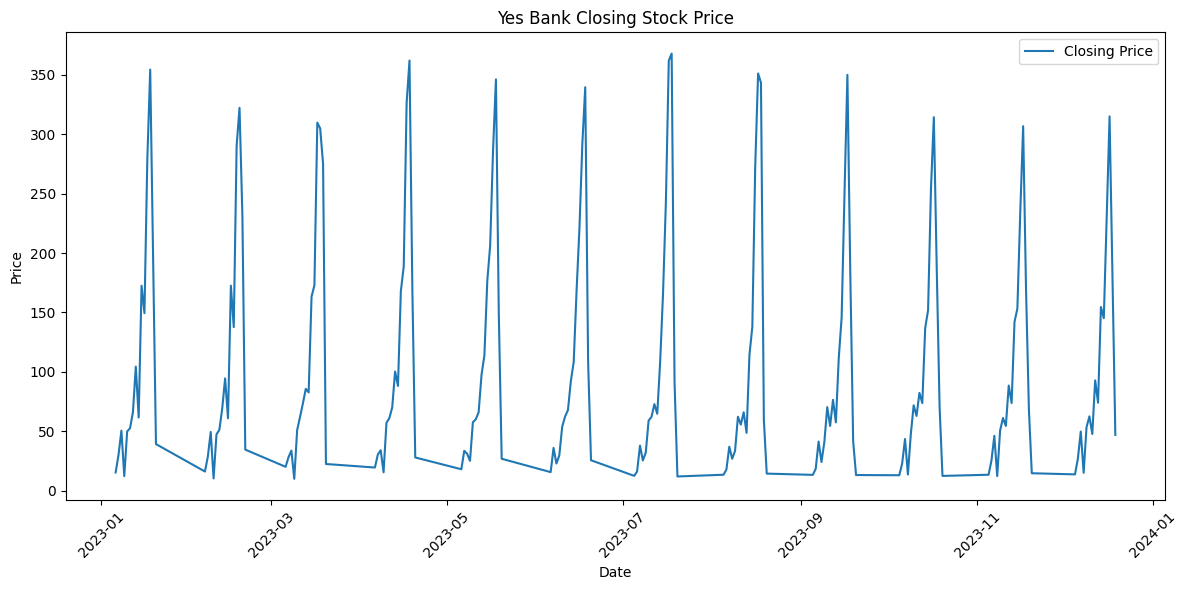

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data_YesBank_StockPrices.csv', parse_dates=['Date'], dayfirst=True)

if df['Date'].dtype != 'datetime64[ns]':
    df['Date'] = '2023-' + df['Date'].astype(str)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%b-%d', errors='coerce')

df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)
df = df.sort_index()

df = df.ffill().bfill()

def plot_closing_price(df):
    plt.figure(figsize=(12,6))
    plt.plot(df['Close'], label='Closing Price')
    plt.title('Yes Bank Closing Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_closing_price(df)


Open     0
High     0
Low      0
Close    0
dtype: int64


<ipython-input-2-2262501390>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


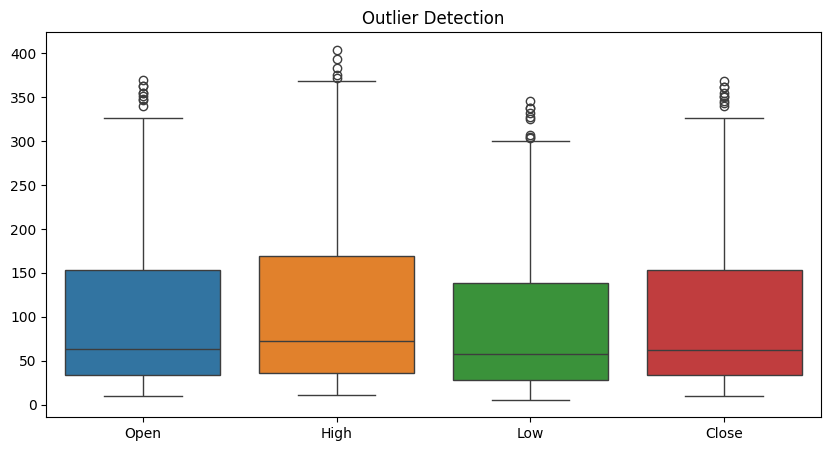

In [2]:
print(df.isnull().sum())

df = df.fillna(method='ffill')

plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']])
plt.title("Outlier Detection")
plt.show()

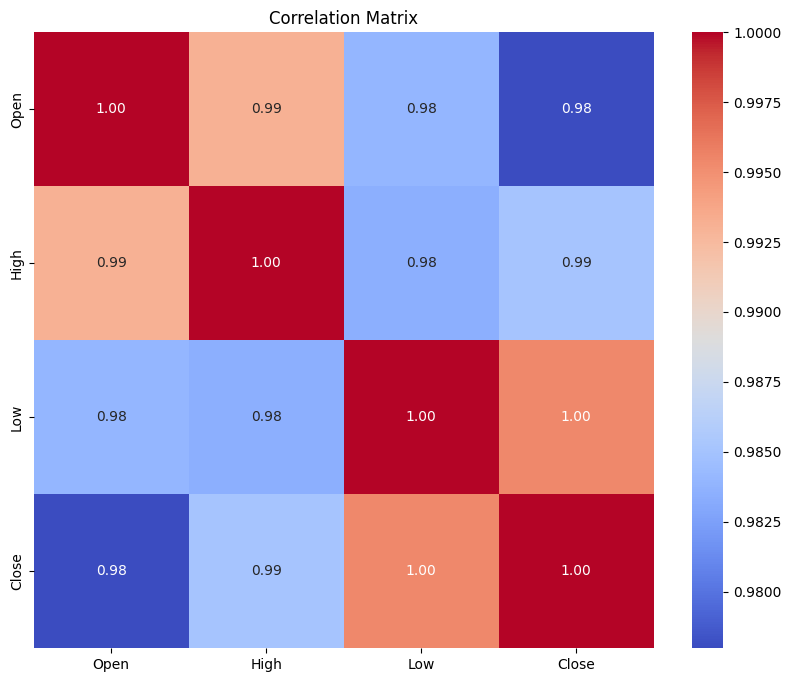

In [3]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [4]:
print("Columns in dataset:", df.columns.tolist())

rename_dict = {}
if 'Open Price' in df.columns:
    rename_dict['Open Price'] = 'Open'
if 'High Price' in df.columns:
    rename_dict['High Price'] = 'High'
if 'Low Price' in df.columns:
    rename_dict['Low Price'] = 'Low'
if 'Close Price' in df.columns:
    rename_dict['Close Price'] = 'Close'
if 'Total Turnover (Rs.)' in df.columns:
    rename_dict['Total Turnover (Rs.)'] = 'Turnover'

df.rename(columns=rename_dict, inplace=True)

print("Renamed columns:", df.columns.tolist())

feature_cols = ['Open', 'High', 'Low']
X = df[feature_cols]
y = df['Close']


Columns in dataset: ['Open', 'High', 'Low', 'Close']
Renamed columns: ['Open', 'High', 'Low', 'Close']


In [5]:
split_ratio = 0.8
split_point = int(len(df) * split_ratio)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (148, 3), Test shape: (37, 3)


In [6]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(name, y_true, y_pred):
    print(f"{name:<18} | R²: {r2_score(y_true, y_pred):.4f} "
    f"| RMSE: {mean_squared_error(y_true, y_pred) ** 0.5:.4f} "
          f"| MAE: {mean_absolute_error(y_true, y_pred):.4f}")

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

evaluate_model("Linear Regression", y_test, y_pred_lr)

Linear Regression  | R²: 0.9912 | RMSE: 8.4783 | MAE: 4.2158


In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate_model("Random Forest", y_test, y_pred_rf)

Random Forest      | R²: 0.9847 | RMSE: 11.1832 | MAE: 6.9157


In [9]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'n_estimators':      [100, 200, 300],
    'max_depth':         [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

evaluate_model("Best RF (grid)", y_test, y_pred_best)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best RF (grid)     | R²: 0.9845 | RMSE: 11.2554 | MAE: 7.1187


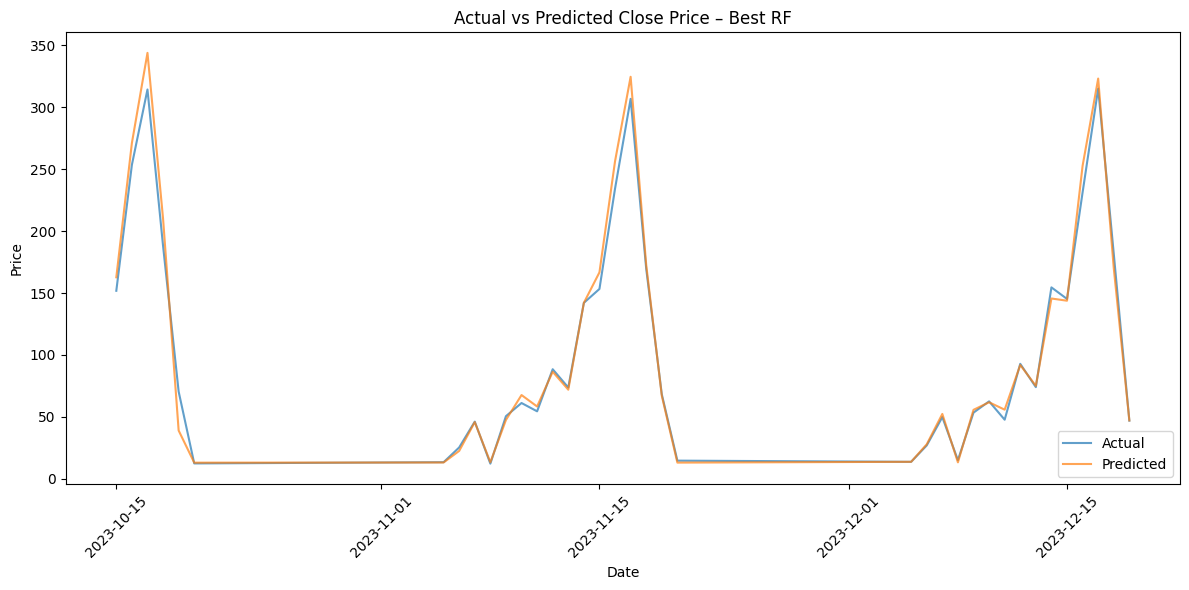

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred_best, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Close Price – Best RF')
plt.xlabel('Date'); plt.ylabel('Price')
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()

In [11]:
import joblib
joblib.dump(best_rf, 'best_rf_yesbank.pkl')
print("✓  Saved best model to 'best_rf_yesbank.pkl'")

✓  Saved best model to 'best_rf_yesbank.pkl'
